In [5]:
from skimage import io
import skimage.segmentation as seg
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import seaborn as sns
from PIL import Image

In [33]:
N_SEGMENTS = 1000
MAX_ITER = 10

### Loading data

In [34]:
image = np.load('scenes_b4b6b7/b4b6b7_x02.npy')
truth = np.load('truth_masks/truth_x02.npy').squeeze()

* 1 = DESMATA
* 2 = FLORESTA
* 3 = NÃO ANALISA

In [35]:
truth = truth * 85

In [36]:
np.unique(truth)

array([ 85, 170, 255], dtype=uint8)

In [37]:
mask = np.where(((truth != 0) & (truth != 255)), 1, 0) * 255

In [38]:
# image = color.gray2rgb(image)

In [39]:
print(f'image shape: {image.shape}')
print(f'mask shape: {mask.shape}')

image shape: (933, 1343, 3)
mask shape: (933, 1343)


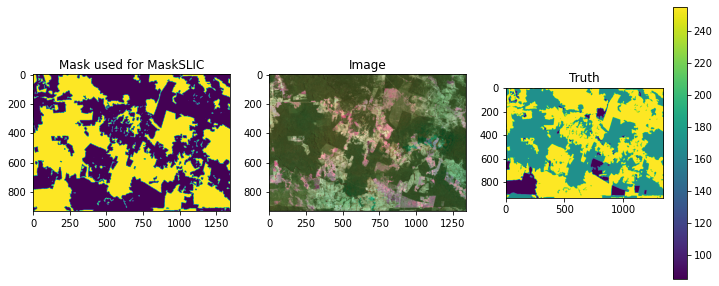

In [40]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12,5)
ax[0].imshow(mask)
ax[0].set_title('Mask used for MaskSLIC')
ax[1].imshow(image)
ax[1].set_title('Image')
ax[2].imshow(truth)
ax[2].set_title('Truth')
fig.colorbar(ax[2].imshow(truth))

### Applying MaskSLIC

In [41]:
image_slic = seg.slic(image, n_segments=N_SEGMENTS, max_num_iter=MAX_ITER, mask=mask, convert2lab=True)

In [42]:
image_with_bounds = seg.mark_boundaries(image=image, label_img=image_slic)
# image_with_bounds = np.uint8(image_with_bounds)

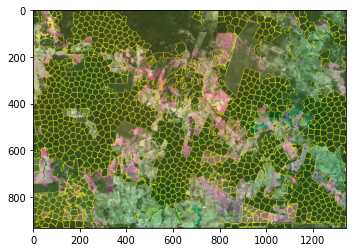

In [43]:
# io.imsave('outputs/yn02-8b_pca_seg.png', image_with_bounds)
plt.imshow(image_with_bounds)

In [44]:
shape = image_with_bounds.shape[:2] + (4,)
shape

(933, 1343, 4)

In [126]:
# export
transparent = np.zeros(shape=image_with_bounds.shape)
transparent_with_bounds = seg.mark_boundaries(image=transparent, label_img=image_slic)

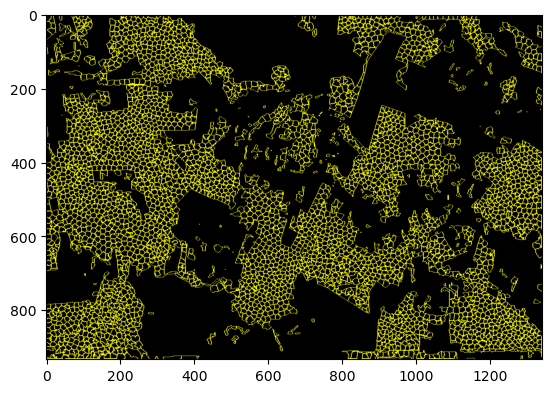

In [127]:
plt.imshow(transparent_with_bounds)

In [128]:
np.unique(transparent_with_bounds)

array([0., 1.])

In [129]:
transparent_with_bounds = np.dstack((transparent_with_bounds, np.zeros(transparent_with_bounds.shape[:2])))
print(transparent_with_bounds.shape)

(933, 1343, 4)


In [130]:
transparent_with_bounds = np.where(transparent_with_bounds != [0,0,0,0], 255, 0)
print(f'twb shape: {transparent_with_bounds.shape}')

twb shape: (933, 1343, 4)


In [131]:
plt.imsave('test.png', np.uint8(transparent_with_bounds))

In [132]:
np.unique(transparent_with_bounds)

array([  0, 255])

In [13]:
mask_with_bounds = seg.mark_boundaries(image=truth, label_img=image_slic)
# mask_with_bounds = np.uint8(mask_with_bounds)
io.imsave('outputs/yn02-8b_truth_seg.png', mask_with_bounds)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Calculating _HoR_

In [14]:
props = regionprops(image_slic)

In [15]:
segments_yn01 = []
segments_yn01_raw = []
assert image_slic.shape == truth.shape
for i, prop in enumerate(props):
    # print(f'prop {i}')
    # print(prop.bbox)
    # print(prop.coords)
    minr, minc, maxr, maxc = prop.bbox
    segment = np.zeros((maxr - minr, maxc - minc))
    raw_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
    coords = np.array(prop.coords)
    for pixel in coords:
        segment[pixel[0] - minr, pixel[1] - minc] = truth[pixel[0], pixel[1]]
        raw_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
      
    segments_yn01.append(segment)
    segments_yn01_raw.append(raw_segment)

In [16]:
print(np.unique(truth))

[  0  85 170 255]


In [17]:
print(len(props))

3582


In [18]:
# 0 - Fundo
# 85 - Desmatamento recente
# 170 - Floresta
# 255 - Ñ analisado

def is_mixed(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 170)
    NP = np.count_nonzero(segment) # desconsiderando o fundo (np.zeros)
    NNP = NP - NFP

    if NFP != 0 and NNP != 0:
        return True
    

    return False
    
def get_hor(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 170)
    NP = np.count_nonzero(segment) # desconsiderando o fundo
    NNP = NP - NFP

    HoR = max([NFP, NNP]) / NP

    return HoR


In [19]:
mean_hor = 0.
mean_hor_bad = 0.
num_perfect_mixed = 0
bad_segments = []
bad_segments_raw = []
hors = []
mixed_hors = []
for i, segment in enumerate(segments_yn01):
    hor = get_hor(segment)
    mean_hor += hor
    if is_mixed(segment):
        mixed_hors.append(hor)
        if hor == 1:
            num_perfect_mixed += 1
    hors.append(hor)
    if hor <= 0.70:
        bad_segments.append(segment)
        bad_segments_raw.append(np.uint8(segments_yn01_raw[i]))
        mean_hor_bad += hor
mean_hor /= len(hors)
mean_hor_bad /= len(bad_segments)

print(f'Mean global HoR for yn02-8b: {mean_hor :.5f}')
print(f'Mean mixed segment HoR for yn02-8b: {np.asarray(mixed_hors).mean() :.5f}')
print(f'Total perfect segmentations across mixed segments (HoR == 1): {num_perfect_mixed}')
print(f'Total bad segmentations (HoR <= 0.70): {len(bad_segments)}')
print(f'Mean HoR across bad segments (yn02-8b): {mean_hor_bad :.5f}')


Mean global HoR for yn02-8b: 0.98025
Mean mixed segment HoR for yn02-8b: 0.84684
Total perfect segmentations across mixed segments (HoR == 1): 0
Total bad segmentations (HoR <= 0.70): 84
Mean HoR across bad segments (yn02-8b): 0.60145


<AxesSubplot: >

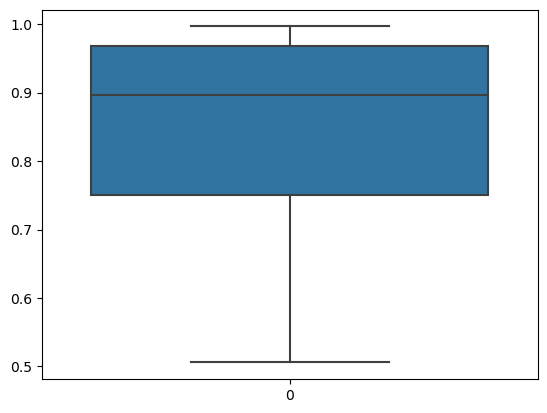

In [20]:
# mixed hor boxplot
sns.boxplot(mixed_hors)

### Analizing bad segments

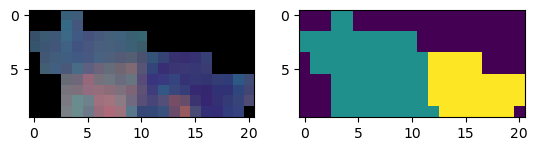

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(bad_segments_raw[0])
ax[1].imshow(bad_segments[0])

## Re-segmentation

In [22]:
# re-segmentation
N_SEGMENTS = 4
MAX_ITER = 10
re_segmentations = []
slics = []
for i, segment in enumerate(bad_segments):
    mask = np.where(((segment != 0)), 1, 0) * 255
    
    segment_slic = seg.slic(bad_segments_raw[i], n_segments=N_SEGMENTS, max_num_iter=MAX_ITER, mask=mask, convert2lab=True)
    props = regionprops(segment_slic)
    repeated_segmentation = []
    for i, prop in enumerate(props):
        minr, minc, maxr, maxc = prop.bbox
        re_segment = np.zeros((maxr - minr, maxc - minc))
        # raw_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
        coords = np.array(prop.coords)
        for pixel in coords:
            re_segment[pixel[0] - minr, pixel[1] - minc] = segment[pixel[0], pixel[1]]
            
            # raw_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
        # print(re_segment.shape)
        
        re_segmentations.append(re_segment)
        
    # re_segmentations.append(np.asarray(repeated_segmentation))
    slics.append(segment_slic)

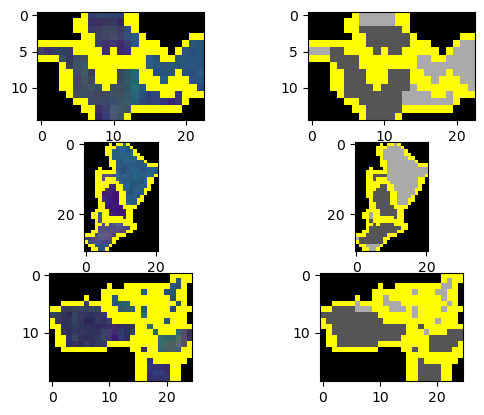

In [23]:
SAMPLE_SIZE = 3
fig, ax = plt.subplots(SAMPLE_SIZE, 2)
for n, idx in enumerate(np.random.randint(0, len(bad_segments), SAMPLE_SIZE)):
    image_with_bounds = seg.mark_boundaries(image=bad_segments_raw[idx], label_img=slics[idx])
    mask_with_bounds = seg.mark_boundaries(image=np.uint8(bad_segments[idx]), label_img=slics[idx])
    ax[n, 0].imshow(image_with_bounds)
    ax[n, 1].imshow(mask_with_bounds)

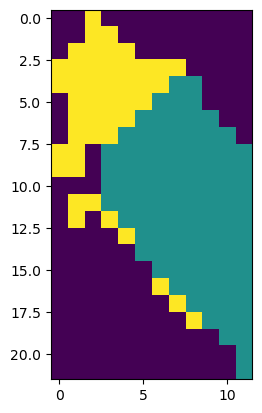

In [24]:
plt.imshow(re_segmentations[7])
# HoR = 1

In [25]:
print(f'Mean bad segment HoR before: {mean_hor_bad :.5f}')
mean_hor_bad = []
num_perfect = 0
for segment in re_segmentations:
    hor = get_hor(segment)
    # print(f'uau: {hor}')
    mean_hor_bad.append(hor)
    if hor == 1:
        num_perfect += 1
mean_hor_bad = np.array(mean_hor_bad)
print(f'Mean bad segment HoR after: {mean_hor_bad.mean() :.5f}')
print(f'Total perfect segmentations (HoR == 1): {num_perfect}')

Mean bad segment HoR before: 0.60145
Mean bad segment HoR after: 0.83564
Total perfect segmentations (HoR == 1): 66
